In [ ]:
import pandas as pd

# Read the TSV file
df = pd.read_csv("train.enhi.df.short.tsv", sep="\t")

# Display the first few rows
print(df.head())

   index                                           original  \
0      0  [citation needed] Four leaf phases are recogni...   
1      1  This rule is so strictly enforced that, even w...   
2      2  At the urging of the International Monetary Fu...   
3      3         He quit the movement and turned to Sufism.   
4      4  He immediately sent a message to the Thakur of...   

                                         translation             scores  \
0  एक यूकेलिप्टस पौधे के विकास में चार पत्ती चरण ...   [75, 75, 77, 82]   
1  यह नियम इतनी सख्ती से लागू किया गया है कि जहां...   [90, 90, 65, 65]   
2  अंतर्राष्ट्रीय मुद्रा कोष (आईएमएफ) के आग्रह पर...   [95, 95, 89, 80]   
3  उन्होंने आंदोलन छोड़ दिया और सूफीवाद की ओर मुड...  [100, 95, 79, 82]   
4    उन्होंने तुरंत असोटा के ठाकुर को एक संदेश भेजा।  [100, 95, 76, 70]   

    mean                                           z_scores    z_mean  
0  77.25  [-1.115305097972482, -1.0486684179242434, 0.42... -0.256664  
1  77.50  [0.1260903044456

In [ ]:
# step1: Text Preprocessing

In [ ]:
# required Libraries
# Lemmenitatization and Stemming
! pip install snowballstemmer
# install Spacy
!pip install spacy
!python -m spacy download en_core_web_sm
!python -m spacy download xx_sent_ud_sm
# Spelling Correction in Multilingual Pipeline
!pip install textblob
!python -m textblob.download_corpora
# install autocorrect for spelling correction
!pip install autocorrect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 37.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 11.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('xx_sent_ud_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[n

In [ ]:
import pandas as pd
import re
import unicodedata
import spacy
import snowballstemmer  # Hindi stemming
from autocorrect import Speller  # Spell correction

# Load spaCy models
nlp_en = spacy.load("en_core_web_sm")  # English NLP model
nlp_hi = spacy.load("xx_sent_ud_sm")   # Multilingual model (for Hindi)

# Initialize tools
stemmer_hi = snowballstemmer.stemmer("hindi")
spell_checker = Speller(lang="en")  # English spell checker

# Define Hindi stopwords manually (since spaCy lacks them)
stopwords_hi = set([
    'और', 'का', 'है', 'के', 'को', 'की', 'से', 'में', 'पर', 'था', 'कि', 'यह',
    'हो', 'हैं', 'तो', 'नहीं', 'एक', 'भी', 'जो', 'रहा', 'कर', 'लिए', 'अपने',
    'ने', 'मैं', 'तक', 'उन', 'होता', 'इसी', 'जैसे', 'किया', 'उस', 'था', 'इसे',
    'आप', 'अब', 'अगर', 'अधिक', 'आदि', 'इस', 'इसमें', 'इन्हें', 'इन्हों', 'उसे',
    'उन्हें', 'उन्हों', 'एवं', 'कई', 'कहते', 'कौन', 'गया', 'घर', 'जब', 'जहां',
    'जहाँ', 'जितना', 'जिन', 'जिन्हें', 'तब', 'तरह', 'दिया', 'दूसरे', 'द्वारा',
    'न', 'नहीं', 'ना', 'पहल', 'फिर', 'बनी', 'बाद', 'बिलकुल', 'भी', 'मगर', 'मुझे',
    'मेरे', 'यदि', 'यही', 'यहाँ', 'युवा', 'रखें', 'रहा', 'रहें', 'लिए', 'व', 'वर्ग',
    'वह', 'वहाँ', 'वाले', 'विस्तार', 'वे', 'संग', 'सकता', 'सकते', 'सब', 'सभी',
    'साथ', 'सिर्फ', 'सुस्पष्ट', 'होना', 'होने', 'हुए', 'ही'
])

def clean_text(text, lang="en", use_stemming=False):
    """Cleans text using regex, NLP (spaCy), spell correction (English), and stemming (Hindi)."""

    if isinstance(text, list):  # Convert list to string if needed
        text = " ".join(text)

    # Unicode normalization
    text = unicodedata.normalize("NFKC", text)

    # Remove citations like [1], [citation needed], etc.
    text = re.sub(r"\[\s?[^\]]+\]", "", text)

    # Lowercase (for English)
    if lang == "en":
        text = text.lower()

    # Spell correction (English only)
    if lang == "en":
        text = spell_checker(text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # Select the correct spaCy model
    nlp = nlp_en if lang == "en" else nlp_hi
    doc = nlp(text)

    # Tokenization, stopword removal, and processing
    cleaned_tokens = []
    for token in doc:
        if lang == "en":
            if not token.is_stop and not token.is_punct:
                cleaned_tokens.append(token.lemma_)  # Lemmatization for English
        elif lang == "hi":
            if token.text not in stopwords_hi and not token.is_punct:
                stemmed_token = stemmer_hi.stemWord(token.text) if use_stemming else token.text
                cleaned_tokens.append(stemmed_token)  # Stemming (if enabled)

    return " ".join(cleaned_tokens)

# Apply preprocessing
df["original_lemmatized"] = df["original"].apply(lambda x: clean_text(x, lang="en"))
df["translation_stemmed"] = df["translation"].apply(lambda x: clean_text(x, lang="hi", use_stemming=True))

# View result
df.head(3)



,index,original,translation,scores,mean,z_scores,z_mean,original_lemmatized,translation_stemmed
0,0,[citation needed] Four leaf phases are recogni...,एक यूकेलिप्टस पौधे के विकास में चार पत्ती चरण ...,"[75, 75, 77, 82]",77.25,"[-1.115305097972482, -1.0486684179242434, 0.42...",-0.256664,leaf phase recognise development eucalyptus pl...,यूकेलिप्टस पौध विकास चार पत्त चरण पहच ज हैंः अ...
1,1,"This rule is so strictly enforced that, even w...",यह नियम इतनी सख्ती से लागू किया गया है कि जहां...,"[90, 90, 65, 65]",77.50,"[0.12609030444560904, 0.2069211629237486, -0.8...",-0.341263,rule strictly enforce conflict interest confli...,नियम इत सख्त लाग हित टकराव य कर्तव्य टकराव विश...
2,2,At the urging of the International Monetary Fu...,अंतर्राष्ट्रीय मुद्रा कोष (आईएमएफ) के आग्रह पर...,"[95, 95, 89, 80]",89.75,"[0.539888771918306, 0.6254510232064127, 1.6680...",0.839132,urging international monetary fund imf governm...,अंतर्राष्ट्रीय मुद्र कोष आईएमएफ आग्रह सरकार सर...


In [ ]:
# Step2 : BERT Tokenizer for subword tokenizaion which is best for transformer based models

In [ ]:
# import nltk.data
# print(nltk.data.find("tokenizers/punkt"))

In [ ]:
# Updated Preprocessing with Stopword Removal
from transformers import AutoTokenizer

# Load multilingual tokenizer (supports English, Hindi, etc.)
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

def clean_text_bert(text):
    tokens = tokenizer.tokenize(text)
    return " ".join(tokens)

# Apply preprocessing
df["original_clean"] = df["original"].apply(clean_text_bert)
df["translation_clean"] = df["translation"].apply(clean_text_bert)

print(df)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

      index                                           original  \
0         0  [citation needed] Four leaf phases are recogni...   
1         1  This rule is so strictly enforced that, even w...   
2         2  At the urging of the International Monetary Fu...   
3         3         He quit the movement and turned to Sufism.   
4         4  He immediately sent a message to the Thakur of...   
...     ...                                                ...   
6995   6995  The formal announcement of the discovery of th...   
6996   6996       As a result, he began an agitation movement.   
6997   6997  Sold at the Baadal Thandai shop in Godowlia Ch...   
6998   6998  Jauhar was committed in the houses of Patta, A...   
6999   6999  Spices are traditionally ground in a ghotna (a...   

                                            translation              scores  \
0     एक यूकेलिप्टस पौधे के विकास में चार पत्ती चरण ...    [75, 75, 77, 82]   
1     यह नियम इतनी सख्ती से लागू किया गया है कि ज

In [ ]:
def merge_subwords(text):
    return text.replace(" ##", "").replace("##", "")

df["translation_clean"] = df["translation_clean"].apply(merge_subwords)

In [ ]:
df.head(3)

,index,original,translation,scores,mean,z_scores,z_mean,original_lemmatized,translation_stemmed,original_clean,translation_clean
0,0,[citation needed] Four leaf phases are recogni...,एक यूकेलिप्टस पौधे के विकास में चार पत्ती चरण ...,"[75, 75, 77, 82]",77.25,"[-1.115305097972482, -1.0486684179242434, 0.42...",-0.256664,leaf phase recognise development eucalyptus pl...,यूकेलिप्टस पौध विकास चार पत्त चरण पहच ज हैंः अ...,[ citation needed ] Four leaf phases are recog...,एक यूकेलिप्टस पौधे के विकास में चार पत्ती चरण ...
1,1,"This rule is so strictly enforced that, even w...",यह नियम इतनी सख्ती से लागू किया गया है कि जहां...,"[90, 90, 65, 65]",77.50,"[0.12609030444560904, 0.2069211629237486, -0.8...",-0.341263,rule strictly enforce conflict interest confli...,नियम इत सख्त लाग हित टकराव य कर्तव्य टकराव विश...,"This rule is so strictly en ##forced that , ev...",यह नियम इतनी सख्ती से लागू किया गया है कि जहां...
2,2,At the urging of the International Monetary Fu...,अंतर्राष्ट्रीय मुद्रा कोष (आईएमएफ) के आग्रह पर...,"[95, 95, 89, 80]",89.75,"[0.539888771918306, 0.6254510232064127, 1.6680...",0.839132,urging international monetary fund imf governm...,अंतर्राष्ट्रीय मुद्र कोष आईएमएफ आग्रह सरकार सर...,At the ur ##ging of the International Monetary...,अंतर्राष्ट्रीय मुद्रा कोष ( आईएमएफ ) के आग्रह ...


In [ ]:
# step 3 :  Extracts statistical, semantic, and length-based features
# Computes sentence embeddings and cosine similarity
# Outputs a ready-to-use dataframe for training

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util
from sklearn.preprocessing import StandardScaler
import joblib

# Load a multilingual sentence embedding model
model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")

# Function to compute sentence embeddings
def get_embedding(text):
    return model.encode(text, convert_to_numpy=True) if isinstance(text, str) else np.zeros(768)

# Compute sentence embeddings
df["original_embedding"] = df["original_clean"].apply(get_embedding)
df["translation_embedding"] = df["translation_clean"].apply(get_embedding)

# Compute cosine similarity between original & translation
df["cosine_similarity"] = df.apply(lambda row: util.cos_sim(row["original_embedding"], row["translation_embedding"]).item(), axis=1)

# Length-based features
df["original_length"] = df["original_clean"].apply(lambda x: len(str(x)))
df["translation_length"] = df["translation_clean"].apply(lambda x: len(str(x)))
df["length_diff"] = df["original_length"] - df["translation_length"]
df["char_ratio"] = df["translation_length"] / df["original_length"]

# Word-based features
df["original_word_count"] = df["original_clean"].apply(lambda x: len(str(x).split()))
df["translation_word_count"] = df["translation_clean"].apply(lambda x: len(str(x).split()))
df["word_count_diff"] = df["original_word_count"] - df["translation_word_count"]

# Score-based features
df["score_std"] = df["scores"].apply(lambda x: np.std(eval(str(x))) if isinstance(x, str) else 0)  # Ensure proper list parsing
df["min_score"] = df["scores"].apply(lambda x: min(eval(str(x))) if isinstance(x, str) else 0)
df["max_score"] = df["scores"].apply(lambda x: max(eval(str(x))) if isinstance(x, str) else 0)

# Select relevant features
feature_columns = [
    "cosine_similarity", "length_diff", "char_ratio", "word_count_diff",
    "score_std", "min_score", "max_score", "z_mean"
]

# Normalize numerical features
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])
joblib.dump(scaler, "scaler.pkl")
# Save processed dataset
df[feature_columns + ["mean"]].to_csv("qe_features.csv", index=False)

print("Feature extraction complete! Data saved as 'qe_features.csv'")


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Feature extraction complete! Data saved as 'qe_features.csv'


In [ ]:
# step 4 Model Training

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Load the extracted feature dataset
df = pd.read_csv("qe_features.csv")

# Define features (X) and target variable (y)
X = df.drop(columns=["mean"])  # Features
y = df["mean"]  # Target: Translation quality score

# Split data into train & test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    print(f"{model_name} Performance:")
    print(f" MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f" RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f" R² Score: {r2_score(y_true, y_pred):.4f}")
    print("-" * 50)

evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")

# Save trained models

joblib.dump(rf_model, "random_forest_qe.pkl")
joblib.dump(xgb_model, "xgboost_qe.pkl")

print("Models trained and saved as 'random_forest_qe.pkl' & 'xgboost_qe.pkl'")


Random Forest Performance:
 MAE: 0.1733
 RMSE: 0.3539
 R² Score: 0.9978
--------------------------------------------------
XGBoost Performance:
 MAE: 0.1854
 RMSE: 0.3676
 R² Score: 0.9976
--------------------------------------------------
Models trained and saved as 'random_forest_qe.pkl' & 'xgboost_qe.pkl'


In [ ]:
# step 5: Testing Data

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sentence_transformers import SentenceTransformer, util

# Load new test data
new_data = pd.read_csv('dev.enhi.df.short.tsv', sep="\t")

# Load trained models
rf_model = joblib.load("random_forest_qe.pkl")
xgb_model = joblib.load("xgboost_qe.pkl")

# Load Sentence Transformer model
model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")

# Function to compute sentence embeddings
def get_embedding(text):
    return model.encode(text, convert_to_numpy=True) if isinstance(text, str) else np.zeros(768)

# Function to extract features from new data
def extract_features(row):
    features = {}

    original = row["original"]
    translation = row["translation"]

    # Compute sentence embeddings
    original_embedding = get_embedding(original)
    translation_embedding = get_embedding(translation)

    # Compute cosine similarity
    features["cosine_similarity"] = util.cos_sim(original_embedding, translation_embedding).item()

    # Length-based features
    features["original_length"] = len(original)
    features["translation_length"] = len(translation)
    features["length_diff"] = features["original_length"] - features["translation_length"]
    features["char_ratio"] = features["translation_length"] / features["original_length"] if features["original_length"] > 0 else 0

    # Word count features
    features["original_word_count"] = len(original.split())
    features["translation_word_count"] = len(translation.split())
    features["word_count_diff"] = features["original_word_count"] - features["translation_word_count"]

    # Score-based features
    try:
        score_list = eval(str(row["scores"]))  # Ensure `scores` is a list
        features["score_std"] = np.std(score_list)
        features["min_score"] = min(score_list)
        features["max_score"] = max(score_list)
    except:
        features["score_std"] = 0
        features["min_score"] = 0
        features["max_score"] = 0

    # Extract `z_mean`
    features["z_mean"] = row["z_mean"]

    return features

# Apply feature extraction on each row
feature_list = new_data.apply(extract_features, axis=1).tolist()

# Convert extracted features into a DataFrame
feature_df = pd.DataFrame(feature_list)

# Ensure feature columns match training data
expected_features = ["cosine_similarity", "length_diff", "char_ratio", "word_count_diff",
                     "score_std", "min_score", "max_score", "z_mean"]

feature_df = feature_df[expected_features]  # Keep only necessary features

# Normalize features using the same scaler from training
scaler = joblib.load("scaler.pkl")  # Load the scaler used during training
feature_df = pd.DataFrame(scaler.transform(feature_df), columns=expected_features)

# Save processed test features
feature_df.to_csv("qe_test_features.csv", index=False)

print("Test feature extraction complete! Data saved as 'qe_test_features.csv'")


Test feature extraction complete! Data saved as 'qe_test_features.csv'


In [ ]:
# Step8: Predicting Data

In [ ]:
# Predict translation quality using both models
rf_predictions = rf_model.predict(feature_df)
xgb_predictions = xgb_model.predict(feature_df)

# Print results
for i, row in new_data.iterrows():
    print(f"Original: {row['original']}")
    print(f"Translation: {row['translation']}")
    print(f"Random Forest Prediction: {rf_predictions[i]:.2f}")
    print(f"XGBoost Prediction: {xgb_predictions[i]:.2f}")
    print("-" * 50)



Original: In the flood-prone districts of the Netherlands, particularly in the northern provinces of Friesland and Groningen, villages were traditionally built on low man-made hills called terpen before the introduction of regional dyke-systems.
Translation: नीदरलैंड के बाढ़ संभावित जिलों में, विशेष रूप से उत्तरी प्रांतों फ्रीसलैंड और ग्रोनिंगेन में, गांवों को पारंपरिक रूप से कम मानव निर्मित पहाड़ियों पर बनाया जाता था जिसे क्षेत्रीय डाइक-सिस्टम की शुरुआत से पहले टेरपेन कहा जाता था।
Random Forest Prediction: 85.03
XGBoost Prediction: 84.94
--------------------------------------------------
Original: Group A Group B The top five run scorers (total runs) are included in this table.
Translation: ग्रुप ए ग्रुप बी शीर्ष पांच रन स्कोरर (कुल रन) इस तालिका में शामिल हैं।
Random Forest Prediction: 91.53
XGBoost Prediction: 91.47
--------------------------------------------------
Original: The final finished as a draw, with Essex winning the tournament, after securing a lead in the first innings 

In [ ]:
# Analysis

Random Forest QE Scores:
count    1000.000000
mean       80.825300
std         8.116296
min        30.887500
25%        77.661875
50%        82.428750
75%        85.806875
max        96.950000
dtype: float64

XGBoost QE Scores:
count    1000.000000
mean       80.843811
std         8.096832
min        22.448727
25%        77.728670
50%        82.401020
75%        85.867476
max        97.931229
dtype: float64


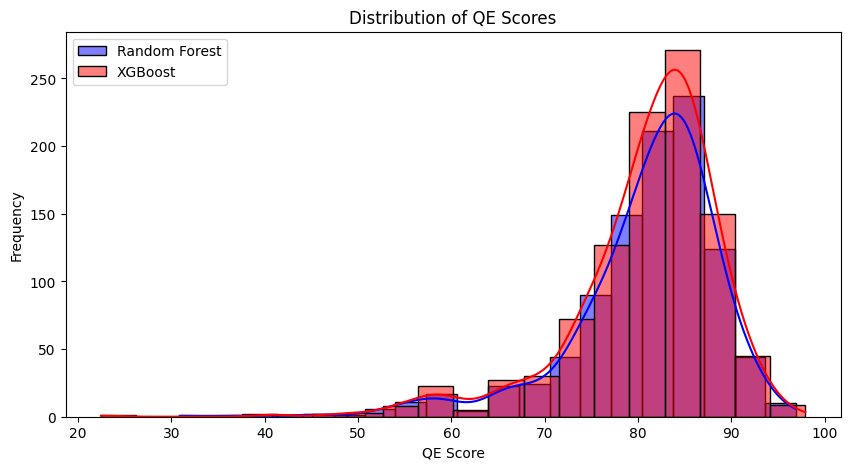

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Print basic statistics
print("Random Forest QE Scores:")
print(pd.Series(rf_predictions).describe())

print("\nXGBoost QE Scores:")
print(pd.Series(xgb_predictions).describe())

# Plot histogram of predictions
plt.figure(figsize=(10, 5))
sns.histplot(rf_predictions, bins=20, color='blue', label="Random Forest", kde=True)
sns.histplot(xgb_predictions, bins=20, color='red', label="XGBoost", kde=True)
plt.xlabel("QE Score")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of QE Scores")
plt.show()


In [ ]:
from scipy.stats import pearsonr

rf_corr, _ = pearsonr(rf_predictions, new_data["z_mean"])
xgb_corr, _ = pearsonr(xgb_predictions, new_data["z_mean"])

print(f"Random Forest QE Correlation with Human Scores: {rf_corr:.2f}")
print(f"XGBoost QE Correlation with Human Scores: {xgb_corr:.2f}")


Random Forest QE Correlation with Human Scores: 1.00
XGBoost QE Correlation with Human Scores: 1.00


In [ ]:
qe_threshold = 0.5  # Example: Adjust based on distribution

new_data["rf_quality"] = ["Good" if score >= qe_threshold else "Bad" for score in rf_predictions]
new_data["xgb_quality"] = ["Good" if score >= qe_threshold else "Bad" for score in xgb_predictions]

# Print first few results
print(new_data[["original", "translation", "rf_quality", "xgb_quality"]].head(10))


                                            original  \
0  In the flood-prone districts of the Netherland...   
1  Group A Group B The top five run scorers (tota...   
2  The final finished as a draw, with Essex winni...   
3  These traits—establishment of a working method...   
4  Its two most important members, Britain and Fr...   
5  A map he made of North and South America is al...   
6  Websites that utilize PPC ads will display an ...   
7    It formed part of the ICC World Cricket League.   
8  Scheduled Castes numbered 4,641 and Scheduled ...   
9  A triangle ABC that has the sides a, b, c, sem...   

                                         translation rf_quality xgb_quality  
0  नीदरलैंड के बाढ़ संभावित जिलों में, विशेष रूप ...       Good        Good  
1  ग्रुप ए ग्रुप बी शीर्ष पांच रन स्कोरर (कुल रन)...       Good        Good  
2  मैच की पहली पारी में बढ़त हासिल करने के बाद, ए...       Good        Good  
3  ये विशेषताएं-कला का अभिन्न अंग कार्य प्रणाली क...       Good        

In [ ]:
new_data["ensemble_qe"] = (rf_predictions + xgb_predictions) / 2


In [ ]:
print(new_data)

     index                                           original  \
0        0  In the flood-prone districts of the Netherland...   
1        1  Group A Group B The top five run scorers (tota...   
2        2  The final finished as a draw, with Essex winni...   
3        3  These traits—establishment of a working method...   
4        4  Its two most important members, Britain and Fr...   
..     ...                                                ...   
995    995  The design has been compared to George Gilbert...   
996    996  He is called to witness the wedding ceremony a...   
997    997  One of the main attractions of Varanasi is the...   
998    998      The region then came under British influence.   
999    999                  Goat meat is generally preferred.   

                                           translation              scores  \
0    नीदरलैंड के बाढ़ संभावित जिलों में, विशेष रूप ...    [90, 90, 79, 81]   
1    ग्रुप ए ग्रुप बी शीर्ष पांच रन स्कोरर (कुल रन)...    [95, 

In [ ]:
from scipy.stats import pearsonr, spearmanr

# Extract human scores (z_mean)
human_scores = new_data["z_mean"]

# Pearson correlation (measures linear correlation)
pearson_rf, _ = pearsonr(rf_predictions, human_scores)
pearson_xgb, _ = pearsonr(xgb_predictions, human_scores)

# Spearman correlation (measures rank correlation)
spearman_rf, _ = spearmanr(rf_predictions, human_scores)
spearman_xgb, _ = spearmanr(xgb_predictions, human_scores)

# Print results
print(f" Pearson Correlation (Random Forest & Human Scores): {pearson_rf:.4f}")
print(f" Pearson Correlation (XGBoost & Human Scores): {pearson_xgb:.4f}\n")

print(f" Spearman Correlation (Random Forest & Human Scores): {spearman_rf:.4f}")
print(f" Spearman Correlation (XGBoost & Human Scores): {spearman_xgb:.4f}")


 Pearson Correlation (Random Forest & Human Scores): 0.9986
 Pearson Correlation (XGBoost & Human Scores): 0.9977

 Spearman Correlation (Random Forest & Human Scores): 0.9977
 Spearman Correlation (XGBoost & Human Scores): 0.9977


In [ ]:
# Pearson correlation tells you if the QE model predicts scores proportionally to human scores.

# Spearman correlation tells you if the QE model ranks translations in the same order as humans.

# If Spearman is high but Pearson is low, the model captures ranking but might be bad at assigning the correct numerical values.

# If both are high, your QE model is very well-aligned with human judgments!

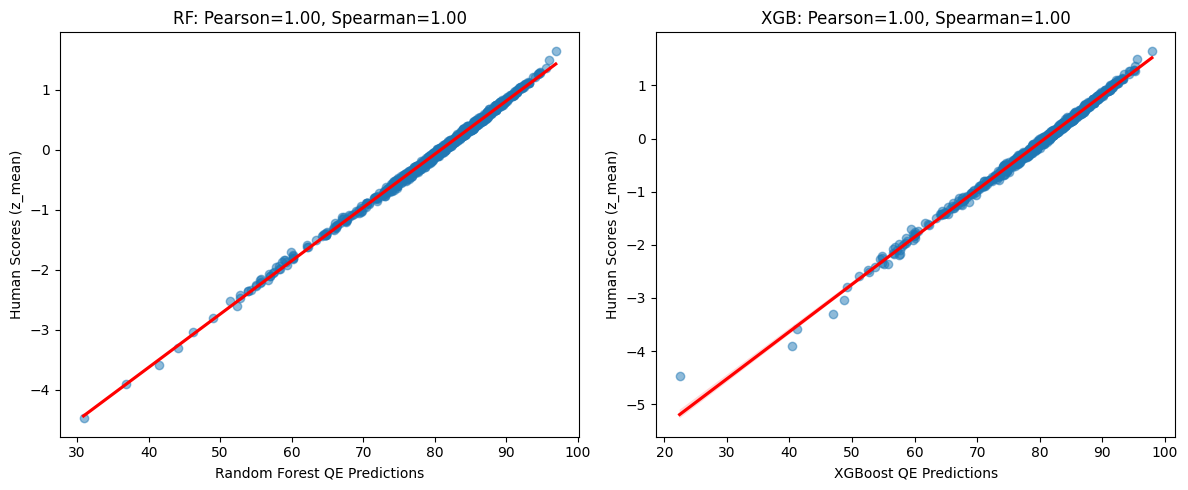

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Scatter plot for Random Forest QE predictions
plt.subplot(1, 2, 1)
sns.regplot(x=rf_predictions, y=human_scores, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel("Random Forest QE Predictions")
plt.ylabel("Human Scores (z_mean)")
plt.title(f"RF: Pearson={pearson_rf:.2f}, Spearman={spearman_rf:.2f}")

# Scatter plot for XGBoost QE predictions
plt.subplot(1, 2, 2)
sns.regplot(x=xgb_predictions, y=human_scores, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.xlabel("XGBoost QE Predictions")
plt.ylabel("Human Scores (z_mean)")
plt.title(f"XGB: Pearson={pearson_xgb:.2f}, Spearman={spearman_xgb:.2f}")

plt.tight_layout()
plt.show()


In [ ]:
# sanity check

In [ ]:
new_data['mean']

,mean
0,85.00
1,91.50
2,80.00
3,84.00
4,88.50
...,...
995,82.25
996,92.50
997,91.25
998,84.50


In [ ]:
rf = []
xgb = []

# Print results
for i, row in new_data.iterrows():
    rf.append(float(rf_predictions[i]))
    xgb.append(float(xgb_predictions[i]))

In [ ]:
 finalData = pd.DataFrame({
     'DA_Score': new_data['mean'],
     'RF_Score': rf,
     'XGB_Score': xgb
 })

In [ ]:
finalData

,DA_Score,RF_Score,XGB_Score
0,85.00,85.0250,84.938011
1,91.50,91.5250,91.469299
2,80.00,80.4375,80.476318
3,84.00,84.0275,84.087486
4,88.50,88.5300,88.533356
...,...,...,...
995,82.25,82.4975,82.537399
996,92.50,92.4475,92.450180
997,91.25,91.2575,91.223564
998,84.50,84.7225,84.739326


In [ ]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# Calculate correlations
pearson_corr, _ = pearsonr(finalData["DA_Score"], finalData["RF_Score"])
spearman_corr, _ = spearmanr(finalData["DA_Score"], finalData["RF_Score"])

print(f"Pearson correlation: {pearson_corr:.4f}")
print(f"Spearman correlation: {spearman_corr:.4f}")


Pearson correlation: 0.9992
Spearman correlation: 0.9991


In [ ]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# Calculate correlations
pearson_corr, _ = pearsonr(finalData["DA_Score"], finalData["XGB_Score"])
spearman_corr, _ = spearmanr(finalData["DA_Score"], finalData["XGB_Score"])

print(f"Pearson correlation: {pearson_corr:.4f}")
print(f"Spearman correlation: {spearman_corr:.4f}")

Pearson correlation: 0.9986
Spearman correlation: 0.9992


In [ ]:
finalData[["DA_Score", "RF_Score"]].corr(method='pearson')   # For Pearson
finalData[["DA_Score", "RF_Score"]].corr(method='spearman')  # For Spearman

,DA_Score,RF_Score
DA_Score,1.000000,0.999057
RF_Score,0.999057,1.000000


In [ ]:
finalData[["DA_Score", "XGB_Score"]].corr(method='pearson')   # For Pearson
finalData[["DA_Score", "XGB_Score"]].corr(method='spearman')  # For Spearman

,DA_Score,XGB_Score
DA_Score,1.00000,0.99921
XGB_Score,0.99921,1.00000


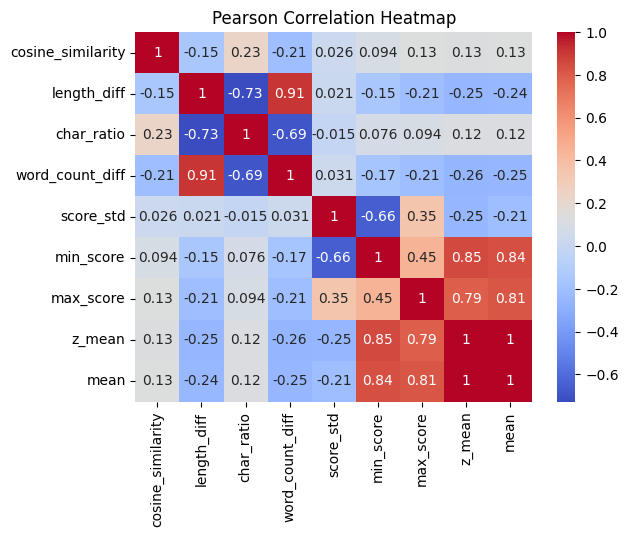

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.corr(method='pearson'), annot=True, cmap='coolwarm')
plt.title("Pearson Correlation Heatmap")
plt.show()

In [ ]:
# This heatmap shows Pearson correlation coefficients between several features in your dataset, and it reveals how strongly each pair of features is linearly related (on a scale from -1 to 1). Here's what it tells you:

# 🔥 Key Takeaways:
# 1. Strong Positive Correlations:
# length_diff ↔️ word_count_diff: 0.91

# Strong linear relationship: as length difference increases, word count difference also increases.

# min_score, max_score, mean, z_mean: All very strongly correlated (≥ 0.79)

# Suggests that min/max/mean/z_mean scores track each other closely — possibly redundant features.

# 2. Strong Negative Correlations:
# length_diff ↔️ char_ratio: -0.73

# char_ratio ↔️ word_count_diff: -0.69

# These features move in opposite directions: e.g., when the length difference is high, character ratio drops.

# 3. Weak or No Correlation:
# cosine_similarity has weak correlations with everything (between -0.21 to 0.23).

# Suggests that semantic similarity (cosine) is mostly orthogonal to structural features (like length or word count).

# score_std is weakly correlated with others except min_score (-0.66), meaning:

# More variation in scores may be linked to lower minimum scores.

# How You Can Use This:
# Feature Selection:

# You can consider dropping highly correlated features to avoid multicollinearity (e.g., maybe keep one of length_diff or word_count_diff).

# Also consider dimensionality reduction (like PCA) or using models that handle correlated features well (like tree-based models).

# Interpretability:

# cosine_similarity and structural features are largely independent — good if you're building a diverse feature set.

# If you're predicting something like translation quality, the high correlations among min/max/mean scores suggest those features dominate the score signal.

# Model Insights:

# If you're doing regression, this heatmap gives clues about which features might drive your predictions and how they interact.

# Let me know if you want help analyzing which features contribute most to model performance, or how to reduce redundancy in your features.








